# **RADIOMICS ANALYSIS - Machine Learning**

(*Step 11*)

## **Radiomics Workflow:**
  
  **1. Download** DICOM images and convert to **NRRD.**

  **2.** Perform **target segmentations** and save in **NRRD.**
  
  **3.** Perform a **first Radiomic Features** ***Dummy*** **Extraction,** to:
    
  - Detect **erros in segmentations**: only one dimension, no label 1, only one segmented voxel...
  - Analyze **binwith**.


  **4. Analyze** and **correct mask errors.**

  **5. Adjust binwith.**
   - **Tune featureextractor param file.**


  **6.** Perform **final Radiomic Feature Extraction.**

  **7. Clean Radiomic Features.**

  **8. Merge** with **labels** and **clinical data.**

  **9. Descriptive Statistics.**

  **10. Inferential Statistics.**

  **11. Machine Learning.**

## **MACHINE LEARNING**

0. Environment **configuration.**
1. **Load** data
2. **Filter** Patients without segmentations
3. **Check** Variables & Datatypes
4. Data **pre-preprocessing**
  * 4.1. Separate numerical data.
  * 4.2. Filter radiomic features.
  * 4.3. Add age and sex.
  * 4.4. Encode labels and reset index.
  * 4.5. Identify false negative patients.

5. **Feature selection**
  * 5.1. Statistical - based selection.
  * 5.2. Randon Forest - based selection.
  * 5.3. Statistical and Random Forest most important features.

6. **Dimensionality reduction**
  * 6.1. PCA

7. **Data processing**
  * 7.1. Removal of nonan.
  * 7.2. Standarization.

8. **Supervised Machine Learning**
  * 8.1. Support Vector Machine (SVM)
  * 8.2. K-nearest neighbours (KNN).
  * 8.3. Decision tree (DT).
  * 8.4. Random forest (RF).
  * 8.5. Logistic regression (LR).
  * 8.6. Best model.
    * 8.6.1. Exploring the best model
    * 8.6.2. Plotting ROC curve and Precission-Recall
    * 8.6.3. Analysis with a cohort of false negatives

9. **Unsupervised Machine Learning**
  * 9.1. Hierarchical Clustering

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_curve, auc, roc_curve, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.impute import SimpleImputer, KNNImputer
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import warnings

### **0. Environment configuration**

#### Set the working directory

In [2]:
# Set working directory
wd = '/Users/pablomenendezfernandez-miranda/Proyecto Otosclerosis/'
os.chdir(wd)

print(f'Directorio actual: {os.getcwd()}')

# Check directory files
#print(f'Directory files: {os.listdir(wd)}')

Directorio actual: /Users/pablomenendezfernandez-miranda/Proyecto Otosclerosis


#### Define useful functions

In [3]:
# Pint full dataframe
def df_show_full(show):
  if show == True:
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
  if show == False:
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')

# Save Table
def df_save_tab(df_tab, path, name):
  df_tab.to_excel(path + name + '.xlsx')
  df_tab.to_csv(path + name + '.csv')

#### Hide warnings

In [4]:
warnings.filterwarnings('ignore')

#### Mount Drive (if executed on Google Colab)

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

### **1. Load data**



In [6]:
# Load data
df_dir= 'Databases/6_df_radiomics_&_clinical.feather'
df_all_patientes= pd.read_feather(df_dir)
print(df_all_patientes.shape)

(127, 1347)


### **2. Filter Patients with segmentations**

In [7]:
# Select Radiomic Feature columns
R_cols= [col for col in df_all_patientes.columns if col.startswith('R_')]

# Remove rows with all NaN in Radiomic Feature columns (patients without segmentations)
df = df_all_patientes.dropna(subset=R_cols, axis=0, how='all')

# Get patients removed
diff = df_all_patientes.merge(df, how='left', indicator=True)
patients_removed= list(diff.loc[diff['_merge'] == 'left_only', 'EPI_CODE'])
patients_removed.sort()

# Print report
print(f'{len(patients_removed)} removed patientes: {patients_removed}') # Other patients are not
print('')

print(df.shape)
df.head(4)

28 removed patientes: ['EPI_0010', 'EPI_0011', 'EPI_0013', 'EPI_0017', 'EPI_0018', 'EPI_0033', 'EPI_0036', 'EPI_0039', 'EPI_0043', 'EPI_0044', 'EPI_0045', 'EPI_0049', 'EPI_0050', 'EPI_0053', 'EPI_0054', 'EPI_0055', 'EPI_0059', 'EPI_0065', 'EPI_0070', 'EPI_0073', 'EPI_0079', 'EPI_0084', 'EPI_0098', 'EPI_0099', 'EPI_0108', 'EPI_0109', 'EPI_0124', 'EPI_0125']

(99, 1347)


,EPI_CODE,Sex,Pathological_Ear,Hearing_impairment_Pathological_Ear,Sensorineural_impairment_dB_250Hz,Sensorineural_impairment_dB_500Hz,Sensorineural_impairment_dB_1000Hz,Sensorineural_impairment_dB_2000Hz,Sensorineural_impairment_dB_3000Hz,Sensorineural_impairment_dB_4000Hz,...,R_OW_lbp-3D-k_glszm_SmallAreaEmphasis,R_OW_lbp-3D-k_glszm_SmallAreaLowGrayLevelEmphasis,R_OW_lbp-3D-k_glszm_ZoneVariance,R_OW_lbp-3D-k_gldm_DependenceEntropy,R_OW_lbp-3D-k_gldm_DependenceNonUniformity,R_OW_lbp-3D-k_gldm_DependenceNonUniformityNormalized,R_OW_lbp-3D-k_gldm_LargeDependenceEmphasis,R_OW_lbp-3D-k_gldm_LargeDependenceLowGrayLevelEmphasis,R_OW_lbp-3D-k_ngtdm_Busyness,R_OW_lbp-3D-k_ngtdm_Strength
0,EPI_0001,Hombre,Oído izquierdo,Moderado (40-70 dB),25.0,35.0,35.0,45.0,35.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,EPI_0002,Mujer,Oído izquierdo,Moderado (40-70 dB),0.0,10.0,20.0,30.0,10.0,5.0,...,1.00,0.43,0.0,1.584963e+00,3.0,1.0,1.0,0.43,0.65625,3.301587
2,EPI_0003,Mujer,Oído derecho,Moderado (40-70 dB),35.0,35.0,25.0,60.0,55.0,50.0,...,0.25,0.25,0.0,-3.203427e-16,2.0,1.0,4.0,4.00,0.00000,0.000000
3,EPI_0004,Hombre,Oído derecho,Moderado (40-70 dB),0.0,5.0,20.0,30.0,20.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### **3. Check Variables & Datatypes**


In [8]:
# Check variables
#print(df.columns.to_list())

In [9]:
# Check datatypes
dtypes_count= df.dtypes.value_counts()

objects=    dtypes_count[dtypes_count.index == 'object'].sum()
floats64=   dtypes_count[dtypes_count.index == 'float64'].sum()
categories= dtypes_count[dtypes_count.index == 'category'].sum()

print(f"object:   {objects}")
print(f"float64:  {floats64}")
print(f"category: {categories}")

object:   1
float64:  1332
category: 14


### **4. Data pre-processing**
  * 4.1. Separate numerical data
  * 4.2. Filter radiomic features
  * 4.3. Add age and sex
  * 4.4. Encode labels and reset index
  * 4.5. Identify false negative patients

#### **4.1. Separate numerical data**

In [10]:
# Select Quantitative and Categorical variables
idx_quantitatives= [idx for idx, dtype in enumerate (df.dtypes) if dtype == 'float64']
idx_categories=    [idx for idx, dtype in enumerate (df.dtypes) if dtype == 'category']

quantitatives= df.columns[idx_quantitatives]
categories=    df.columns[idx_categories]

print(f'Quantitatives: {len(quantitatives)}')
print(f'Categories (Qualitatives): {len(categories)}')

Quantitatives: 1332
Categories (Qualitatives): 14


In [11]:
X_numerical = df[quantitatives].copy()
y = df['Label'].copy()

print(X_numerical.shape)
print(y.shape)

(99, 1332)
(99,)


#### **4.2. Filter radiomic features**

In [12]:
# From all quantitatives filter radiomic features
X_features = X_numerical.loc[:, X_numerical.columns.str.startswith('R_')]
X_features.shape

(99, 1319)

#### **4.3. Add age and sex**

In [13]:
# Select age and sex

label_encoder = LabelEncoder()
X_features.insert (0, 'age', df['age'].values)
X_features.insert(1, 'sex', label_encoder.fit_transform(df['Sex'].astype(str).values))

print(f'Label 0 - {label_encoder.classes_[0]}\nLabel 1 - {label_encoder.classes_[1]}\n')
print(X_features.shape)

Label 0 - Hombre
Label 1 - Mujer

(99, 1321)


#### **4.4. Encode labels and reset index**

In [14]:
# Reset index
X_features.reset_index(drop=True, inplace=True)

# Encode labels
y = label_encoder.fit_transform(y)

print(X_features.shape)
print(y.shape)

(99, 1321)
(99,)


#### **4.5. Identify false negative patients**

In [15]:
# False negatives
bool_array = df['Label_extended'] == 'NoTC_Otosclerosis'
idx_fp = X_features.index[bool_array]

print(f'False positives (CT - & Otosclerosis +): {list(idx_fp)}')
bool_array.value_counts()

False positives (CT - & Otosclerosis +): [0, 14, 29, 33, 35, 44, 47]


Label_extended
False    92
True      7
Name: count, dtype: int64

### **5. Feature Selection**
  
* 5.1. Statistical - based selection
* 5.2. Random Forest - based selection
* 5.3. Statistical and Random Forest most important features

In [16]:
# Select a number of features (max n_features = n_samples * 0.10)
n_features = 10

#### **5.1. Statistical - based selection**

In [17]:
# Import statistically significant variables from statistical bivariate analysis performed in the previous step

sig_norm_dir= 'Tables/2_2_1s_normal_vars_sig_t_tests.csv'
sig_non_norm_dir= 'Tables/2_2_2s_non_normal_vars_sig_u_tests.csv'

sig_norm_vars= pd.read_csv(sig_norm_dir)
sig_non_norm_vars= pd.read_csv(sig_non_norm_dir)

# Concatenate DataFrames
sig1= sig_norm_vars    [['Normal Variables', 'FDR corrected p-value']]
sig2= sig_non_norm_vars[['Non_normal Variables', 'FDR corrected p-value']]

sig1= sig1.rename(columns={'Normal Variables':'Variable'})
sig2= sig2.rename(columns={'Non_normal Variables':'Variable'})

sig_vars= pd.concat([sig1, sig2]).sort_values(by=['FDR corrected p-value'], ascending=True)
sig_vars= list(sig_vars['Variable'])

print(f'Significant variables: {len(sig_vars)} - {sig_vars}')

Significant variables: 67 - ['R_AF_wavelet-LHH_firstorder_Mean', 'R_AF_log-sigma-1-0-mm-3D_firstorder_Mean', 'R_AF_gradient_firstorder_Median', 'R_AF_gradient_firstorder_Mean', 'R_AF_log-sigma-5-0-mm-3D_firstorder_Range', 'R_AF_original_firstorder_Mean', 'R_AF_logarithm_firstorder_10Percentile', 'R_AF_wavelet-LLL_firstorder_Mean', 'R_AF_original_firstorder_InterquartileRange', 'R_AF_gradient_firstorder_90Percentile', 'R_AF_original_firstorder_Skewness', 'R_AF_lbp-3D-m1_firstorder_MeanAbsoluteDeviation', 'R_AF_lbp-3D-m1_glcm_Contrast', 'R_AF_exponential_glrlm_LongRunLowGrayLevelEmphasis', 'R_AF_exponential_gldm_DependenceVariance', 'R_AF_log-sigma-5-0-mm-3D_firstorder_InterquartileRange', 'R_AF_log-sigma-4-0-mm-3D_firstorder_Entropy', 'R_STAPES_original_shape_MajorAxisLength', 'R_AF_log-sigma-4-0-mm-3D_firstorder_Range', 'R_AF_wavelet-LLL_firstorder_10Percentile', 'R_AF_log-sigma-2-0-mm-3D_firstorder_90Percentile', 'R_AF_wavelet-LHH_firstorder_RootMeanSquared', 'R_AF_lbp-3D-m1_firstorde

In [18]:
# Select the most statistically significant features + age and sex as covariates
features_sig = ['age', 'sex'] + sig_vars[:n_features]

X_features_sig = X_features[features_sig].copy()
print(X_features_sig.shape)

(99, 12)


#### **5.2. Random Forest - based selection**

In [19]:
# Random Forest
X_= X_features.copy()
y_= y.copy()

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_, y_)

# Obtain feature importance
importances = rf.feature_importances_

# Create a DataFrame with feature importances
feature_names = X_.columns if hasattr(X_, 'columns') else [f'Feature {i}' for i in range(X_.shape[1])]
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)
rf_features= list(importance_df['Feature'])

# Print results
#print(rf_features)
df_show_full(True)
importance_df.head(10)

,Feature,Importance
521,R_AF_logarithm_firstorder_10Percentile,0.020447
729,R_AF_wavelet-LHH_firstorder_RootMeanSquared,0.015435
640,R_AF_log-sigma-4-0-mm-3D_firstorder_Entropy,0.012461
554,R_AF_gradient_firstorder_Mean,0.011771
475,R_AF_original_firstorder_Mean,0.009954
735,R_AF_wavelet-LHH_glszm_LargeAreaEmphasis,0.008794
865,R_AF_lbp-3D-m1_glcm_Contrast,0.008371
725,R_AF_wavelet-LHH_firstorder_Mean,0.008220
762,R_AF_wavelet-HLL_ngtdm_Contrast,0.008049
544,R_AF_exponential_gldm_DependenceVariance,0.007721


In [20]:
# Select the most important features for Random Forest + age and sex as covariates
features_rf = ['age', 'sex'] + rf_features[:n_features]

X_features_rf = X_features[features_rf].copy()
print(X_features_rf.shape)

(99, 12)


#### **5.3. Statistical and Random Forest most important features.**

In [21]:
# Select the most significant and Random Forest - important features
n_top_features = 20

top_sig_features = sig_vars[:n_top_features]
top_rf_features=   rf_features[:n_top_features]

top_sig_rf_features = list(set(top_sig_features).intersection(top_rf_features))

print(f'Most important Statistical and Random Forest features: {len(top_sig_rf_features)} - {top_sig_rf_features}')

Most important Statistical and Random Forest features: 11 - ['R_AF_lbp-3D-m1_firstorder_MeanAbsoluteDeviation', 'R_AF_log-sigma-4-0-mm-3D_firstorder_Entropy', 'R_AF_exponential_gldm_DependenceVariance', 'R_AF_log-sigma-4-0-mm-3D_firstorder_Range', 'R_AF_wavelet-LHH_firstorder_Mean', 'R_AF_original_firstorder_Mean', 'R_AF_logarithm_firstorder_10Percentile', 'R_AF_lbp-3D-m1_glcm_Contrast', 'R_AF_log-sigma-1-0-mm-3D_firstorder_Mean', 'R_AF_gradient_firstorder_Mean', 'R_AF_log-sigma-5-0-mm-3D_firstorder_InterquartileRange']


In [22]:
# Select the most significant and important features
X_features_sig_rf= X_features[['age', 'sex'] + top_sig_rf_features]
print(X_features_sig_rf.shape)

(99, 13)


### **6. Dimensionality reduction**
  * 6.1. PCA

#### **6.1. PCA**

In [23]:
# PCA analysis

class PCA_analysis ():

  def __init__(self, X_, y_, pca_threshold, title):

    self.X_ = X_
    self.y_ = y_
    self.pca_threshold = pca_threshold
    self.title = title


  def PCA_analysis (self):

    # Drop rows with NaN
    X_nonan= self.X_.dropna()
    print(f'X.shape after removing NaN {X_nonan.shape}')

    # Set the pipeline
    #pca = PCA()
    pca = Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA())])
    pca.fit(X_nonan)

    # Variance explained for each component
    # explained_variance = pca.explained_variance_ratio_
    explained_variance = pca.named_steps['pca'].explained_variance_ratio_

    # Cumulative explained variance
    cumulative_variance = np.cumsum(explained_variance)
    self.n_components = np.argmax(cumulative_variance >= self.pca_threshold) + 1

    # Print report
    print('')
    print(f'Number of components to preserve {self.pca_threshold*100}% cumulative variance: {self.n_components} components')
    print(f'From {X_nonan.shape[1]} variables the reduction was to {self.n_components} components, preserving {self.pca_threshold} of variance')
    print('')

    # Plotting explained variance for each component
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(explained_variance) + 1), explained_variance.cumsum(), marker='o', linestyle='--', color='b')
    plt.title(self.title)
    plt.xlabel('n_components')
    plt.ylabel('Variance_explained')
    plt.grid(True)
    plt.show()

    # Return n_components
    return self.n_components

  def PCA_fit (self):

    # Drop rows with NaN
    X_nonan= self.X_.dropna()
    self.y_pca= self.y_[X_nonan.index]

    # Set the pipeline
    pca = Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(self.n_components))])
    pca.fit(X_nonan)
    self.X_pca = pca.transform(X_nonan)

    return self.X_pca, self.y_pca

  def run (self):

    print(f'\n{self.title}')
    print(f'-----------------------------')

    self.PCA_analysis()
    self.PCA_fit()

    return self.X_pca, self.y_pca

PCA features: 63 - ['age', 'R_AF_gradient_firstorder_90Percentile', 'R_STAPES_log-sigma-1-0-mm-3D_firstorder_Energy', 'R_STAPES_wavelet-LLL_firstorder_Skewness', 'R_AF_log-sigma-1-0-mm-3D_firstorder_Energy', 'R_AF_square_glszm_GrayLevelNonUniformity', 'R_OW_wavelet-LHH_firstorder_90Percentile', 'R_AF_gradient_firstorder_InterquartileRange', 'R_AF_original_firstorder_Mean', 'R_AF_log-sigma-4-0-mm-3D_glcm_ClusterProminence', 'R_AF_log-sigma-4-0-mm-3D_firstorder_10Percentile', 'R_AF_squareroot_firstorder_Kurtosis', 'R_AF_wavelet-HLL_ngtdm_Contrast', 'R_AF_log-sigma-5-0-mm-3D_firstorder_InterquartileRange', 'R_AF_wavelet-LLL_firstorder_Mean', 'R_AF_wavelet-HLL_firstorder_Maximum', 'R_AF_log-sigma-2-0-mm-3D_firstorder_Mean', 'R_AF_lbp-3D-k_glcm_ClusterProminence', 'R_AF_log-sigma-4-0-mm-3D_firstorder_Skewness', 'R_AF_log-sigma-4-0-mm-3D_firstorder_InterquartileRange', 'R_AF_log-sigma-5-0-mm-3D_glszm_LargeAreaHighGrayLevelEmphasis', 'R_STAPES_log-sigma-3-0-mm-3D_firstorder_InterquartileRange

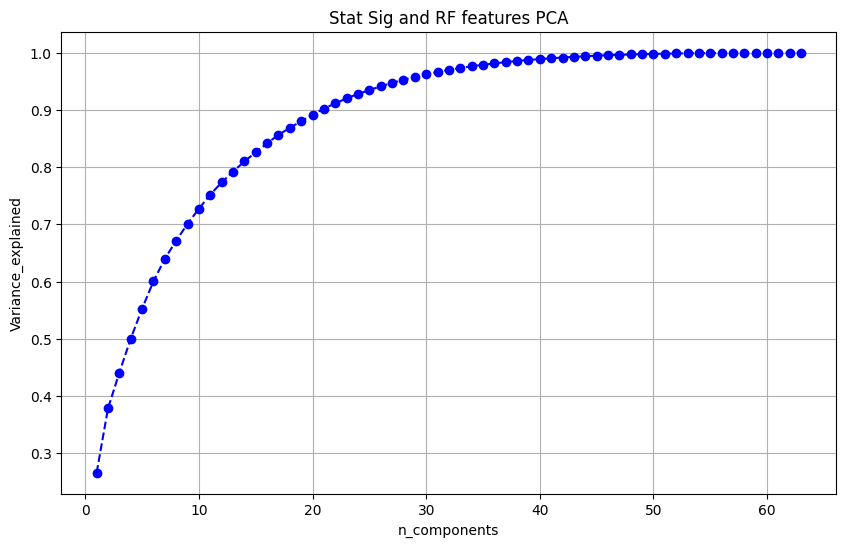

In [24]:
# PCA
n_pca = 40

# Select features for PCA
pca_features = ['age', 'sex'] + sig_vars[:n_pca] + rf_features[:n_pca]
pca_features = list(set(pca_features)) # remove duplicates

print(f'PCA features: {len(pca_features)} - {pca_features}')

# PCA analysis
X_pca, y_pca = PCA_analysis (X_=X_features[pca_features], y_=y, pca_threshold=0.80, title='Stat Sig and RF features PCA').run()

### **7. Data processing**

* 7.1. Removal of nonan
* 7.2. Standarization

#### **7.1. Removal of nonan**

In [25]:
# Remove NaN
X_features_sig_nonnan =    X_features_sig.dropna()
X_features_rf_nonnan =     X_features_rf.dropna()
X_features_sig_rf_nonnan = X_features_sig_rf.dropna()

y_sig =    y[X_features_sig_nonnan.index]
y_rf =     y[X_features_rf_nonnan.index]
y_sig_rf = y[X_features_sig_rf_nonnan.index]

print(X_features_sig_nonnan.shape)
print(y_sig.shape)
print(X_features_rf_nonnan.shape)
print(y_rf.shape)
print(X_features_sig_rf_nonnan.shape)
print(y_sig_rf.shape)

(99, 12)
(99,)
(99, 12)
(99,)
(99, 13)
(99,)


#### **7.2. Standarization**

In [26]:
# Standarization
scaler = StandardScaler()
X_features_sig_scaled =    scaler.fit_transform(X_features_sig_nonnan)
X_features_rf_scaled =     scaler.fit_transform(X_features_rf_nonnan)
X_features_sig_rf_scaled = scaler.fit_transform(X_features_sig_rf_nonnan)

print(X_features_sig_scaled.shape)
print(X_features_rf_scaled.shape)
print(X_features_sig_rf_scaled.shape)

(99, 12)
(99, 12)
(99, 13)


### **8. Supervised Machine Learning**

  * 8.1. Support Vector Machine (SVM)
  * 8.2. K-nearest neighbours (KNN)
  * 8.3. Decision tree (DT)
  * 8.4. Random forest (RF)
  * 8.5. Logistic regression (LR)
  * 8.6. Best model

#### **8.1. Support Vector Machine (SVM)**

In [27]:
# Train SVM

class SVM ():


  def __init__(self, X_, y_, param_grid, k, name):
    self.X_ = X_
    self.y_ = y_
    self.param_grid = param_grid
    self.k = k
    self.name = name


  def train_test_stratify_split (self):

    # Split the data into training and testing sets
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X_, self.y_, test_size=0.2, stratify=self.y_, random_state=0)

    # Check classes are balanced
    #print(dict(zip(*np.unique(self.y_train, return_counts=True))))
    #print(dict(zip(*np.unique(self.y_test, return_counts=True))))


  def SVM_grid_search (self):

    # Build the model
    svm = SVC(probability=False, verbose=False)

    # Set the GridSearchCV
    skf = StratifiedKFold(n_splits=self.k)
    grid_search = GridSearchCV(svm, self.param_grid, cv=skf, scoring='accuracy', refit=True, verbose=0)

    # Train the model using the GridSearchCV
    grid_search.fit(self.X_train, self.y_train)

    # Save best model
    self.best_params= grid_search.best_params_

    # Show the best hyperparameters
    # print(f'{name} best configuration: {grid_search.best_params_}')


  def SVM_best_params (self):

    # Build the model
    self.best_model = SVC(probability=False, verbose=False, **self.best_params)

    # Train the model with the best config and all trainning data
    self.best_model.fit(self.X_train, self.y_train)

    # Evaluate the model
    y_pred = self.best_model.predict(self.X_test)
    test_accuracy = accuracy_score(self.y_test, y_pred)
    test_roc_auc = roc_auc_score(self.y_test, y_pred)

    # Computing confidence interval using bootstrapping
    n_iterations = 1000
    n_size = int(len(self.X_test) * 0.8)  # sample_size = 80% sample_size
    accuracy_scores = []
    auc_scores= []

    for i in range(n_iterations):
        sample_indices = np.random.choice(range(len(self.X_test)), size=n_size, replace=True)
        
        X_sample = self.X_test[sample_indices,:]
        y_sample = self.y_test[sample_indices]

        if len(np.unique(y_sample)) < 2:
            continue
        
        y_pred_sample = self.best_model.predict(X_sample)
        
        accuracy = accuracy_score(y_sample, y_pred_sample)
        accuracy_scores.append(accuracy)
        
        roc_auc = roc_auc_score(y_sample, y_pred_sample)
        auc_scores.append(roc_auc)

    # Compute 95% confidence interval
    #accuracy= np.median(score)
    accuracy= test_accuracy
    accuracy_std= np.std(accuracy_scores)
    accuracy_lower = np.percentile(accuracy_scores, 2.5)
    accuracy_upper = np.percentile(accuracy_scores, 97.5)

    self.roc_auc= test_roc_auc
    self.roc_auc_std= np.std(auc_scores)
    roc_auc_lower = np.percentile(auc_scores, 2.5)
    roc_auc_upper = np.percentile(auc_scores, 97.5)

    # Print results
    print(f'Accuracy: {accuracy:.2f} ± {accuracy_std:.2f} [{accuracy_lower:.2f}, {accuracy_upper:.2f}]')
    print(f'AUC:      {self.roc_auc:.2f} ± {self.roc_auc_std:.2f} [{roc_auc_lower:.2f}, {roc_auc_upper:.2f}]')


  def run (self):
    print(self.name)
    self.train_test_stratify_split()
    self.SVM_grid_search()
    self.SVM_best_params()
    print('')

In [28]:
# Train Support Vector Machine
print('SVM')
print('--------------------')

k = 10

# Define param_grid
svm_param_grid= {'C': [0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8],
                 'gamma': ['scale', 1, 0.1, 0.01, 0.001],  # kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’
                 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}


# SVM with significant standarized features
SVM (X_=X_features_sig_scaled, y_=y_sig, param_grid=svm_param_grid, k=k, name='Significant features').run()

# SVM with random forest standarized features
SVM (X_=X_features_rf_scaled,  y_=y_rf,  param_grid=svm_param_grid, k=k, name='Random forest features').run()

# SVM with Statistical and random forest standarized features
SVM (X_=X_features_sig_rf_scaled,  y_=y_sig_rf,  param_grid=svm_param_grid, k=k, name='Statistical and Random forest features').run()

# SVM with PCA components
SVM (X_=X_pca, y_=y_pca, param_grid=svm_param_grid, k=k, name='PCA components').run()

SVM
--------------------
Significant features
Accuracy: 0.85 ± 0.09 [0.69, 1.00]
AUC:      0.85 ± 0.09 [0.65, 1.00]

Random forest features
Accuracy: 0.60 ± 0.12 [0.38, 0.81]
AUC:      0.60 ± 0.13 [0.35, 0.83]

Statistical and Random forest features
Accuracy: 0.80 ± 0.10 [0.62, 1.00]
AUC:      0.80 ± 0.10 [0.60, 1.00]

PCA components
Accuracy: 0.75 ± 0.13 [0.50, 1.00]
AUC:      0.75 ± 0.13 [0.50, 1.00]



#### **8.2. K-Nearest Neighbours (KNN)**

In [29]:
# K-Nearest neighbours

class KNN ():

  def __init__(self, X_, y_, param_grid, k, name):
    self.X_ = X_
    self.y_ = y_
    self.param_grid = param_grid
    self.k = k
    self.name = name


  def train_test_stratify_split (self):

    # Split the data into training and testing sets
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X_, self.y_, test_size=0.2, stratify=self.y_, random_state=0)
    
    # Check classes are balanced
    #print(dict(zip(*np.unique(self.y_train, return_counts=True))))
    #print(dict(zip(*np.unique(self.y_test, return_counts=True))))


  def KNN_grid_search (self):

    # Build the model
    knn= KNeighborsClassifier()

    # Set the GridSearchCV
    skf = StratifiedKFold(n_splits=self.k)
    grid_search = GridSearchCV(knn, self.param_grid, cv=skf, scoring='accuracy', refit=True, verbose=0)

    # Train the model using the GridSearchCV
    grid_search.fit(self.X_train, self.y_train)

    # Save best model
    self.best_params= grid_search.best_params_

    # Show the best hyperparameters
    # print(f'{name} best configuration: {grid_search.best_params_}')


  def KNN_best_params (self):

    # Build the model
    self.best_model = KNeighborsClassifier(**self.best_params)

    # Train the model with the best config and all trainning data
    self.best_model.fit(self.X_train, self.y_train)

    # Evaluate the model
    y_pred = self.best_model.predict(self.X_test)
    test_accuracy = accuracy_score(self.y_test, y_pred)
    test_roc_auc = roc_auc_score(self.y_test, y_pred)

    # Computing confidence interval using bootstrapping
    n_iterations = 1000
    n_size = int(len(self.X_test) * 0.8)  # sample_size = 80% sample_size
    accuracy_scores = []
    auc_scores= []

    for i in range(n_iterations):
      sample_indices = np.random.choice(range(len(self.X_test)), size=n_size, replace=True)

      X_sample = self.X_test[sample_indices,:]
      y_sample = self.y_test[sample_indices]

      if len(np.unique(y_sample)) < 2:
          continue
          
      y_pred_sample = self.best_model.predict(X_sample)

      accuracy = accuracy_score(y_sample, y_pred_sample)
      accuracy_scores.append(accuracy)

      roc_auc = roc_auc_score(y_sample, y_pred_sample)
      auc_scores.append(roc_auc)

    # Compute 95% confidence interval
    #accuracy= np.median(score)
    accuracy= test_accuracy
    accuracy_std= np.std(accuracy_scores)
    accuracy_lower = np.percentile(accuracy_scores, 2.5)
    accuracy_upper = np.percentile(accuracy_scores, 97.5)

    self.roc_auc= test_roc_auc
    self.roc_auc_std= np.std(auc_scores)
    roc_auc_lower = np.percentile(auc_scores, 2.5)
    roc_auc_upper = np.percentile(auc_scores, 97.5)

    # Print results
    print(f'Accuracy: {accuracy:.2f} ± {accuracy_std:.2f} [{accuracy_lower:.2f}, {accuracy_upper:.2f}]')
    print(f'AUC:      {self.roc_auc:.2f} ± {self.roc_auc_std:.2f} [{roc_auc_lower:.2f}, {roc_auc_upper:.2f}]')


  def run (self):
    print(self.name)
    self.train_test_stratify_split()
    self.KNN_grid_search()
    self.KNN_best_params()
    print('')

In [30]:
# K-Nearest neighbours
print('K-NN')
print('--------------------')

k= 10

# Define param_grid
param_grid_knn = {'n_neighbors': [3, 5, 7, 9, 11],
                  'weights': ['uniform', 'distance'],
                  'metric': ['euclidean', 'manhattan', 'minkowski'],
                  'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                  'leaf_size': [20, 30, 40, 50],
                  'p': [1, 2]}



# KNN with significant standarized features
KNN (X_=X_features_sig_scaled, y_=y_sig, param_grid=param_grid_knn, k=k, name='Significant features').run()

# KNN with random forest standarized features
KNN (X_=X_features_rf_scaled, y_=y_rf, param_grid=param_grid_knn, k=k, name='Random forest features').run()

# KNN with Statistical and random forest standarized features
KNN (X_=X_features_sig_rf_scaled,  y_=y_sig_rf,  param_grid=param_grid_knn, k=k, name='Statistical and Random forest features').run()

# KNN with PCA components
KNN (X_=X_pca, y_=y_pca, param_grid=param_grid_knn, k=k, name='PCA components').run()

K-NN
--------------------
Significant features
Accuracy: 0.85 ± 0.09 [0.69, 1.00]
AUC:      0.85 ± 0.09 [0.68, 1.00]

Random forest features
Accuracy: 0.80 ± 0.09 [0.62, 1.00]
AUC:      0.80 ± 0.10 [0.59, 1.00]

Statistical and Random forest features
Accuracy: 0.80 ± 0.10 [0.56, 1.00]
AUC:      0.80 ± 0.11 [0.56, 1.00]

PCA components
Accuracy: 0.75 ± 0.12 [0.50, 1.00]
AUC:      0.75 ± 0.12 [0.50, 1.00]



#### **8.3. Decision Tree (DT)**

In [31]:
# Decision tree

class DT ():

  def __init__(self, X_, y_, param_grid, k, name):
    self.X_ = X_
    self.y_ = y_
    self.param_grid = param_grid
    self.k = k
    self.name = name


  def train_test_stratify_split (self):

    # Split the data into training and testing sets
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X_, self.y_, test_size=0.2, stratify=self.y_, random_state=0)

    # Check classes are balanced
    #print(dict(zip(*np.unique(self.y_train, return_counts=True))))
    #print(dict(zip(*np.unique(self.y_test, return_counts=True))))


  def DT_grid_search (self):

    # Build the model
    dt = DecisionTreeClassifier()

    # Set the GridSearchCV
    skf = StratifiedKFold(n_splits=self.k)
    grid_search = GridSearchCV(dt, self.param_grid, cv=skf, scoring='accuracy', refit=True, verbose=0)

    # Train the model using the GridSearchCV
    grid_search.fit(self.X_train, self.y_train)

    # Save best model
    self.best_params= grid_search.best_params_

    # Show the best hyperparameters
    # print(f'{name} best configuration: {grid_search.best_params_}')


  def DT_best_params (self):

    # Build the model
    self.best_model = DecisionTreeClassifier(**self.best_params)

    # Train the model with the best config and all trainning data
    self.best_model.fit(self.X_train, self.y_train)

    # Evaluate the model
    y_pred = self.best_model.predict(self.X_test)
    test_accuracy = accuracy_score(self.y_test, y_pred)
    test_roc_auc = roc_auc_score(self.y_test, y_pred)

    # Computing confidence interval using bootstrapping
    n_iterations = 1000
    n_size = int(len(self.X_test) * 0.8)  # sample_size = 80% sample_size
    accuracy_scores = []
    auc_scores= []

    for i in range(n_iterations):
      sample_indices = np.random.choice(range(len(self.X_test)), size=n_size, replace=True)

      X_sample = self.X_test[sample_indices,:]
      y_sample = self.y_test[sample_indices]

      if len(np.unique(y_sample)) < 2:
          continue

      y_pred_sample = self.best_model.predict(X_sample)

      accuracy = accuracy_score(y_sample, y_pred_sample)
      accuracy_scores.append(accuracy)

      roc_auc = roc_auc_score(y_sample, y_pred_sample)
      auc_scores.append(roc_auc)

    # Compute 95% confidence interval
    #accuracy= np.median(score)
    accuracy= test_accuracy
    accuracy_std= np.std(accuracy_scores)
    accuracy_lower = np.percentile(accuracy_scores, 2.5)
    accuracy_upper = np.percentile(accuracy_scores, 97.5)

    self.roc_auc= test_roc_auc
    self.roc_auc_std= np.std(auc_scores)
    roc_auc_lower = np.percentile(auc_scores, 2.5)
    roc_auc_upper = np.percentile(auc_scores, 97.5)

    # Print results
    print(f'Accuracy: {accuracy:.2f} ± {accuracy_std:.2f} [{accuracy_lower:.2f}, {accuracy_upper:.2f}]')
    print(f'AUC:      {self.roc_auc:.2f} ± {self.roc_auc_std:.2f} [{roc_auc_lower:.2f}, {roc_auc_upper:.2f}]')


  def run (self):
    print(self.name)
    self.train_test_stratify_split()
    self.DT_grid_search()
    self.DT_best_params()
    print('')

In [32]:
# Decision tree
print('Decision tree')
print('--------------------')

k= 10

# Define param_grid
param_grid_dt = {'criterion': ['gini', 'entropy'],
                 'splitter': ['best', 'random'],
                 'max_depth': [2, 4, 5, 6, 8, 10],
                 'min_samples_split': [2, 5, 6, 8],
                 'min_samples_leaf': [2, 4, 6],
                 'max_features': ['sqrt', 'log2']}


# DT with significant standarized features
DT (X_=X_features_sig_scaled, y_=y_sig, param_grid=param_grid_dt, k=k, name='Significant features').run()

# DT with random forest standarized features
DT (X_=X_features_rf_scaled, y_=y_rf, param_grid=param_grid_dt, k=k, name='Random forest features').run()

# DT with Statistical and random forest standarized features
DT (X_=X_features_sig_rf_scaled,  y_=y_sig_rf,  param_grid=param_grid_dt, k=k, name='Statistical and Random forest features').run()

# DT with PCA components
DT (X_=X_pca, y_=y_pca, param_grid=param_grid_dt, k=k, name='PCA components').run()

Decision tree
--------------------
Significant features
Accuracy: 0.65 ± 0.12 [0.44, 0.88]
AUC:      0.65 ± 0.11 [0.44, 0.85]

Random forest features
Accuracy: 0.65 ± 0.12 [0.44, 0.88]
AUC:      0.65 ± 0.13 [0.38, 0.88]

Statistical and Random forest features
Accuracy: 0.70 ± 0.12 [0.50, 0.94]
AUC:      0.70 ± 0.12 [0.46, 0.93]

PCA components
Accuracy: 0.62 ± 0.14 [0.33, 0.92]
AUC:      0.62 ± 0.15 [0.33, 0.92]



#### **8.4. Random Forest (RF)**

In [33]:
# Random Forest

class RF ():

  def __init__(self, X_, y_, param_grid, k, name):
    self.X_ = X_
    self.y_ = y_
    self.param_grid = param_grid
    self.k = k
    self.name = name


  def train_test_stratify_split (self):

    # Split the data into training and testing sets
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X_, self.y_, test_size=0.2, stratify=self.y_, random_state=0)
    
    # Check classes are balanced
    #print(dict(zip(*np.unique(self.y_train, return_counts=True))))
    #print(dict(zip(*np.unique(self.y_test, return_counts=True))))


  def RF_grid_search (self):

    # Build the model
    rf = RandomForestClassifier()

    # Set the GridSearchCV
    skf = StratifiedKFold(n_splits=self.k)
    grid_search = GridSearchCV(rf, self.param_grid, cv=skf, scoring='accuracy', refit=True, verbose=0)

    # Train the model using the GridSearchCV
    grid_search.fit(self.X_train, self.y_train)

    # Save best model
    self.best_params= grid_search.best_params_

    # Show the best hyperparameters
    # print(f'{name} best configuration: {grid_search.best_params_}')


  def RF_best_params (self):

    # Build the model
    self.best_model = RandomForestClassifier(**self.best_params)

    # Train the model with the best config and all trainning data
    self.best_model.fit(self.X_train, self.y_train)

    # Evaluate the model
    y_pred = self.best_model.predict(self.X_test)
    test_accuracy = accuracy_score(self.y_test, y_pred)
    test_roc_auc = roc_auc_score(self.y_test, y_pred)

    # Computing confidence interval using bootstrapping
    n_iterations = 1000
    n_size = int(len(self.X_test) * 0.8)  # sample_size = 80% sample_size
    accuracy_scores = []
    auc_scores= []

    for i in range(n_iterations):
      sample_indices = np.random.choice(range(len(self.X_test)), size=n_size, replace=True)

      X_sample = self.X_test[sample_indices,:]
      y_sample = self.y_test[sample_indices]

      if len(np.unique(y_sample)) < 2:
          continue

      y_pred_sample = self.best_model.predict(X_sample)

      accuracy = accuracy_score(y_sample, y_pred_sample)
      accuracy_scores.append(accuracy)

      roc_auc = roc_auc_score(y_sample, y_pred_sample)
      auc_scores.append(roc_auc)

    # Compute 95% confidence interval
    #accuracy= np.median(score)
    accuracy= test_accuracy
    accuracy_std= np.std(accuracy_scores)
    accuracy_lower = np.percentile(accuracy_scores, 2.5)
    accuracy_upper = np.percentile(accuracy_scores, 97.5)

    self.roc_auc= test_roc_auc
    self.roc_auc_std= np.std(auc_scores)
    roc_auc_lower = np.percentile(auc_scores, 2.5)
    roc_auc_upper = np.percentile(auc_scores, 97.5)

    # Print results
    print(f'Accuracy: {accuracy:.2f} ± {accuracy_std:.2f} [{accuracy_lower:.2f}, {accuracy_upper:.2f}]')
    print(f'AUC:      {self.roc_auc:.2f} ± {self.roc_auc_std:.2f} [{roc_auc_lower:.2f}, {roc_auc_upper:.2f}]')


  def run (self):
    print(self.name)
    self.train_test_stratify_split()
    self.RF_grid_search()
    self.RF_best_params()
    print('')

In [34]:
# Random forest
print('Random forest')
print('--------------------')

k= 10

# Define param_grid
param_grid_rf = {'n_estimators': [50, 100],
                 'max_depth': [None, 2, 4, 10],
                 'min_samples_split': [2, 3, 6],
                 'min_samples_leaf': [1, 2, 4]}


# RF with significant standarized features
RF (X_=X_features_sig_scaled, y_=y_sig, param_grid=param_grid_rf, k=k, name='Significant features').run()

# RF with random forest standarized features
RF (X_=X_features_rf_scaled, y_=y_rf, param_grid=param_grid_rf, k=k, name='Random forest features').run()

# RF with Statistical and random forest standarized features
RF (X_=X_features_sig_rf_scaled,  y_=y_sig_rf,  param_grid=param_grid_rf, k=k, name='Statistical and Random forest features').run()

# RF with PCA components
RF (X_=X_pca, y_=y_pca, param_grid=param_grid_rf, k=k, name='PCA components').run()

Random forest
--------------------
Significant features
Accuracy: 0.70 ± 0.12 [0.44, 0.94]
AUC:      0.70 ± 0.11 [0.47, 0.91]

Random forest features
Accuracy: 0.80 ± 0.10 [0.56, 0.94]
AUC:      0.80 ± 0.10 [0.58, 0.96]

Statistical and Random forest features
Accuracy: 0.80 ± 0.09 [0.62, 1.00]
AUC:      0.80 ± 0.10 [0.60, 1.00]

PCA components
Accuracy: 0.81 ± 0.11 [0.58, 1.00]
AUC:      0.81 ± 0.11 [0.60, 1.00]



#### **8.5. Logistic Regression**

In [35]:
# Logistic regression

class logit ():

  def __init__(self, X_, y_, param_grid, k, name):
    self.X_ = X_
    self.y_ = y_
    self.param_grid = param_grid
    self.k = k
    self.name = name


  def train_test_stratify_split (self):

    # Split the data into training and testing sets
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X_, self.y_, test_size=0.30, stratify=self.y_, random_state=0)

    # Check classes are balanced
    #print(dict(zip(*np.unique(self.y_train, return_counts=True))))
    #print(dict(zip(*np.unique(self.y_test, return_counts=True))))


  def lr_grid_search (self):

    # Build the model
    logit = LogisticRegression(penalty='l2', random_state=42)

    # Set the GridSearchCV
    skf = StratifiedKFold(n_splits=self.k)
    grid_search = GridSearchCV(logit, self.param_grid, cv=skf, scoring='accuracy', refit=True, verbose=0)

    # Train the model using the GridSearchCV
    grid_search.fit(self.X_train, self.y_train)

    # Save best model
    self.best_params= grid_search.best_params_

    # Show the best hyperparameters
    # print(f'{name} best configuration: {grid_search.best_params_}')


  def lr_best_params (self):

    # Build the model
    self.best_model = LogisticRegression(penalty='l2', random_state=42, **self.best_params)

    # Train the model with the best config and all trainning data
    self.best_model.fit(self.X_train, self.y_train)

    # Evaluate the model
    y_pred = self.best_model.predict(self.X_test)
    test_accuracy = accuracy_score(self.y_test, y_pred)
    test_roc_auc = roc_auc_score(self.y_test, y_pred)

    # Computing confidence interval using bootstrapping
    n_iterations = 1000
    n_size = int(len(self.X_test) * 0.8)  # sample_size = 80% sample_size
    accuracy_scores = []
    auc_scores= []

    for i in range(n_iterations):
      sample_indices = np.random.choice(range(len(self.X_test)), size=n_size, replace=True)

      X_sample = self.X_test[sample_indices,:]
      y_sample = self.y_test[sample_indices]
      
      if len(np.unique(y_sample)) < 2:
          continue      
    
      y_pred_sample = self.best_model.predict(X_sample)

      accuracy = accuracy_score(y_sample, y_pred_sample)
      accuracy_scores.append(accuracy)

      roc_auc = roc_auc_score(y_sample, y_pred_sample)
      auc_scores.append(roc_auc)

    # Compute 95% confidence interval
    #accuracy= np.median(score)
    accuracy= test_accuracy
    accuracy_std= np.std(accuracy_scores)
    accuracy_lower = np.percentile(accuracy_scores, 2.5)
    accuracy_upper = np.percentile(accuracy_scores, 97.5)

    self.roc_auc= test_roc_auc
    self.roc_auc_std= np.std(auc_scores)
    roc_auc_lower = np.percentile(auc_scores, 2.5)
    roc_auc_upper = np.percentile(auc_scores, 97.5)

    # Print results
    print(f'Accuracy: {accuracy:.2f} ± {accuracy_std:.2f} [{accuracy_lower:.2f}, {accuracy_upper:.2f}]')
    print(f'AUC:      {self.roc_auc:.2f} ± {self.roc_auc_std:.2f} [{roc_auc_lower:.2f}, {roc_auc_upper:.2f}]')


  def run (self):
    print(self.name)
    self.train_test_stratify_split()
    self.lr_grid_search()
    self.lr_best_params()
    print('')

In [36]:
# Logistic regression
print('Logistic regression')
print('--------------------')

k= 10

# Define param_grid
param_grid_lr = {'C': [n/100 for n in range(1,200)]}


# LR with significant standarized features
logit (X_=X_features_sig_scaled, y_=y_sig, param_grid=param_grid_lr, k=k, name='Significant features').run()

# LR with random forest standarized features
logit (X_=X_features_rf_scaled, y_=y_rf, param_grid=param_grid_lr, k=k, name='Random forest features').run()

# LR with Statistical and random forest standarized features
logit (X_=X_features_sig_rf_scaled,  y_=y_sig_rf,  param_grid=param_grid_lr, k=k, name='Statistical and Random forest features').run()

# LR with PCA components
logit (X_=X_pca, y_=y_pca, param_grid=param_grid_lr, k=k, name='PCA components').run()

Logistic regression
--------------------
Significant features
Accuracy: 0.90 ± 0.06 [0.79, 1.00]
AUC:      0.90 ± 0.06 [0.77, 1.00]

Random forest features
Accuracy: 0.77 ± 0.08 [0.58, 0.92]
AUC:      0.77 ± 0.09 [0.59, 0.92]

Statistical and Random forest features
Accuracy: 0.80 ± 0.08 [0.62, 0.96]
AUC:      0.80 ± 0.09 [0.62, 0.96]

PCA components
Accuracy: 0.83 ± 0.09 [0.63, 1.00]
AUC:      0.83 ± 0.09 [0.65, 1.00]



#### **8.6. Best model**

* 8.6.1. Exploring the best model
* 8.6.2. Plotting ROC curve and Precission-Recall
* 8.6.3. Analysis with a cohort of false negatives

##### **8.6.1. Exploring the best model**

In [37]:
# Find best params for best model
model1 = logit (X_=X_features_sig_scaled, y_=y_sig, param_grid=param_grid_lr, k=k, name='Significant features')

# Split training and test data
model1.train_test_stratify_split()

# Search the best hyperparameters
model1.lr_grid_search()

# Get the best hyperparameters
params1= model1.best_params

# Print params
print(f'Best params model 1: {params1}')
print('')

# Training the final model
model1.lr_best_params()

# Compute False Negative Rate
y_pred_model1 = model1.best_model.predict(model1.X_test)

tn, fp, fn, tp = confusion_matrix(model1.y_test, y_pred_model1).ravel()
fpr = fp / (fp + tn)

print(f'FNR:      {round(fpr*100,2)}')

Best params model 1: {'C': 0.21}

Accuracy: 0.90 ± 0.06 [0.79, 1.00]
AUC:      0.90 ± 0.06 [0.78, 1.00]
FNR:      13.33


In [38]:
# Extracting the formula

def get_logit_formula (model, feature_names):

  # Get the coefficients and intercept
  coefficients = model.coef_[0]
  intercept = model.intercept_[0]

  # Print the logistic regression formula
  formula = f'logit(p) = {intercept:.4f}'

  for coef, feature in zip(coefficients, feature_names):
    formula += f' + ({coef:.4f} * {feature})'

  print('Logistic Regression Formula:')
  print(formula)
  print('')

  coefs = pd.DataFrame(data={'Feature':['Intercept'] + list(feature_names), 'Coefficient': [intercept] + list(coefficients)}).round(2)
  display(coefs)

get_logit_formula(model1.best_model, features_sig)

Logistic Regression Formula:
logit(p) = 0.0571 + (-0.0191 * age) + (0.4796 * sex) + (-0.5774 * R_AF_wavelet-LHH_firstorder_Mean) + (0.1137 * R_AF_log-sigma-1-0-mm-3D_firstorder_Mean) + (-0.4308 * R_AF_gradient_firstorder_Median) + (-0.1485 * R_AF_gradient_firstorder_Mean) + (0.5156 * R_AF_log-sigma-5-0-mm-3D_firstorder_Range) + (0.0752 * R_AF_original_firstorder_Mean) + (-0.3873 * R_AF_logarithm_firstorder_10Percentile) + (-0.3160 * R_AF_wavelet-LLL_firstorder_Mean) + (0.0776 * R_AF_original_firstorder_InterquartileRange) + (-0.1060 * R_AF_gradient_firstorder_90Percentile)



,Feature,Coefficient
0,Intercept,0.06
1,age,-0.02
2,sex,0.48
3,R_AF_wavelet-LHH_firstorder_Mean,-0.58
4,R_AF_log-sigma-1-0-mm-3D_firstorder_Mean,0.11
5,R_AF_gradient_firstorder_Median,-0.43
6,R_AF_gradient_firstorder_Mean,-0.15
7,R_AF_log-sigma-5-0-mm-3D_firstorder_Range,0.52
8,R_AF_original_firstorder_Mean,0.08
9,R_AF_logarithm_firstorder_10Percentile,-0.39


##### **8.6.2. Plotting ROC curve and Precission-Recall**

Best Model - LR with significant features



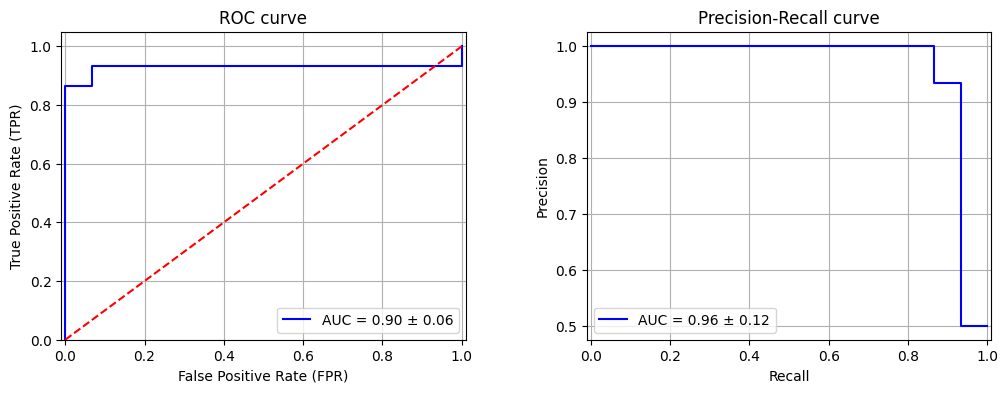

In [39]:
# Plotting ROC curve and Precision-Recall curve

def roc_pr_curves (model_, name):

  model =  model_.best_model
  X_test = model_.X_test
  y_test = model_.y_test

  # Predict
  y_prob = model.predict_proba(X_test)[:, 1] # preserve predictions for label=1

  # ROC curve
  fpr, tpr, thresholds = roc_curve(y_test, y_prob)

  # Precision-Recall curve
  precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
  pr_auc = auc(recall, precision)
  pr_auc_std = np.std([auc(*precision_recall_curve(y_test[np.random.choice(len(y_test), len(y_test), replace=True)], 
                                                   y_prob[np.random.choice(len(y_test), len(y_test), replace=True)])[1::-1]) 
                                                   for _ in range(1000)])

  # Final adjust to avoid little jumps for small samples
    
  def correct_metric (metric):
    corrected_metric= [0]
    for idx, metric_ in enumerate(metric):
          corrected_metric.append(metric[idx-1] if metric_ < corrected_metric[idx] else metric_)
    return corrected_metric[1:]

  corrected_precision= correct_metric(precision)
  corrected_precision= correct_metric(corrected_precision) # avoid two minor prior one value


  # Plotting the curves
  fig, axs = plt.subplots(1, 2, figsize=(12, 4))

  # Plotting ROC curve
  axs[0].plot(fpr, tpr, color='blue', label='AUC = {:.2f} ± {:.2f}'.format(model_.roc_auc, model_.roc_auc_std))
  axs[0].plot([0, 1], [0, 1], color='red', linestyle='--')
  axs[0].set_xlim([-0.01, 1.01])
  axs[0].set_ylim([0.0, 1.05])
  axs[0].set_xlabel('False Positive Rate (FPR)')
  axs[0].set_ylabel('True Positive Rate (TPR)')
  axs[0].set_title('ROC curve')
  axs[0].legend(loc='lower right')
  axs[0].grid()

  # Plotting Precision-Recall curve
  axs[1].plot(recall, corrected_precision, color='blue', label='AUC = {:.2f} ± {:.2f}'.format(pr_auc, pr_auc_std))
  axs[1].set_xlim([-0.01, 1.01])
  #axs[1].set_ylim([0.0, 1.05])
  axs[1].set_xlabel('Recall')
  axs[1].set_ylabel('Precision')
  axs[1].set_title('Precision-Recall curve')
  axs[1].grid(True)
  axs[1].legend(loc='best')


  # Show results
  plt.subplots_adjust(wspace=0.3)
  plt.show()

  # Save plot
  fig.savefig('Figures/4_1_' + name + '.pdf', dpi=600)
  fig.savefig('Figures/4_1_' + name + '.png', dpi=600)

# Print results
print('Best Model - LR with significant features\n')
roc_pr_curves (model1, name='ROC_best_model_LR_sig_features')

 If the model does not predict probabilities close to 0 for any sample, the threshold calculation will not include values that make both FPR and TPR equal to 0. This is common in models like logistic regression, where the predicted probabilities are smoothed and rarely 0 or 1.

##### **8.6.3. Analysis with a cohort of false negatives**

In [40]:
# Analysis with a cohort of false negatives
print(f'False negative patients: {list(idx_fp)}')

# Separate false negative patients
X_features_sig_filtered = np.delete (X_features_sig_scaled, idx_fp, axis=0)
y_sig_filtered =          np.delete (y_sig,                 idx_fp, axis=0)

X_sig_fp =    X_features_sig_scaled [idx_fp]
y_sig_fp =    y_sig                 [idx_fp]

print(X_features_sig_filtered.shape)
print(y_sig_filtered.shape)

print(X_sig_fp.shape)
print(y_sig_fp.shape)

False negative patients: [0, 14, 29, 33, 35, 44, 47]
(92, 12)
(92,)
(7, 12)
(7,)


In [41]:
# Train and test a logistic regression

def logit_fn_test (X_train, y_train, X_test, y_test):

  # Configurate the model
  logit = LogisticRegression(penalty='l2', random_state=42)
  skf = StratifiedKFold(n_splits=10)
  grid_search = GridSearchCV(logit, param_grid={'C': [n/100 for n in range(1,200)]}, cv=skf, scoring='accuracy', refit=True, verbose=0)

  # Train Grid Search
  grid_search.fit(X_train, y_train)

  # Get the best model
  best_model = grid_search.best_estimator_

  # Predict FN sample
  y_pred = best_model.predict(X_test)

  # Compute metrics
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)

  # Compute confusión matrix
  conf_matrix = confusion_matrix(y_test, y_pred)
  tn= conf_matrix[0][0]
  fp= conf_matrix[0][1]
  fn= conf_matrix[1][0]
  tp= conf_matrix[1][1]

  # Print results
  print(f'Best Parameters:      {grid_search.best_params_}')
  print(f'Accuracy:             {accuracy:.2f}')
  print(f'Precision (PPV):      {precision:.2f}')
  print(f'Recall (Sensitivity): {recall:.2f}')
  print(f'F1 Score:             {f1:.2f}')
  print(f'Confusion Matrix:\n  - TP: {tp}\n  - FP: {fp}\n  - FN: {fn}\n  - TN: {tn}')

In [42]:
# Train the model
print('Significant features\n--------------------')
logit_fn_test (X_train=X_features_sig_filtered, y_train=y_sig_filtered, X_test=X_sig_fp, y_test=y_sig_fp)

Significant features
--------------------
Best Parameters:      {'C': 0.54}
Accuracy:             0.29
Precision (PPV):      1.00
Recall (Sensitivity): 0.29
F1 Score:             0.44
Confusion Matrix:
  - TP: 2
  - FP: 0
  - FN: 5
  - TN: 0


### **9. Unsupervised Machine Learning**

* 9.1. Hirarchical Clustering.

#### **9.1. Hirarchical Clustering**

In [43]:
# Hierarchical Clustering for Significant Radiomic Features

def hierarchical_clustering (X_, y_, n_features, figsize, feature_names, NaN, name):

    # Convert data to DataFrame
    df_cluster= pd.DataFrame(data=X_, columns=feature_names)
    df_y= pd.Series(y_)

    # Fill or remove NaN
    if NaN == 'remove':
      df_cluster= df_cluster.dropna()
      df_y= df_y[df_cluster.index]
      print(f'X.shape after removing NaN: {df_cluster.shape}\n')

    elif NaN == 'fill':
      #imputer = SimpleImputer(strategy='median')
      imputer = KNNImputer(n_neighbors=2)
      df_cluster = pd.DataFrame(imputer.fit_transform(df_cluster), columns=feature_names)

    # Select the number of features
    df_cluster_filtered = df_cluster.iloc[:,:n_features]

    # Labels
    label1_colors = {0: '#99FF99', 1: '#9999FF'}
    col_colors1 = df_y.map(label1_colors)

    # Clustermap
    g= sns.clustermap(df_cluster_filtered.T,
                      metric='euclidean',
                      method='ward',
                      #z_score=0,
                      standard_scale=0,
                      row_cluster=False,
                      cmap='viridis',
                      col_colors= pd.DataFrame({'': col_colors1}),
                      cbar_kws=dict(ticks=[0, 0.50, 1], orientation='horizontal'),
                      figsize=figsize)

    # Axis
    # X-axis
    g.ax_heatmap.set_xlabel('Patients', fontsize=18)
    g.ax_heatmap.xaxis.label.set_position((0.5, 0))
    g.ax_heatmap.xaxis.set_ticks([])
    g.ax_heatmap.xaxis.set_ticklabels([])

    # Y-axis
    #g.ax_heatmap.set_ylabel('Features', fontsize=18)
    #g.ax_heatmap.yaxis.label.set_rotation(0)
    #g.ax_heatmap.yaxis.label.set_position((2, 1))
    plt.text(0.6, -4.6, 'Features', fontsize=18)
    
    # Legend
    label_color1 = {'Non-Otosclerosis': '#99FF99', 'Otosclerosis': '#9999FF'}
    legend_patches = [mpatches.Patch(color=color, label=label) for label, color in label_color1.items()]
    plt.legend(handles=legend_patches, title='Group', bbox_to_anchor=(1.05, -0.8), title_fontsize=16, fontsize=12, alignment='left', frameon=False)

    # Color bar
    g.ax_cbar.set_title('Z-score')
    #g.ax_cbar.tick_params(axis='x', length=10)
    g.cax.set_position([0.8, 1, 0.1, 0.05]) # [x, y, width, heigh]
    
    # Plotting the clustermap
    plt.show()

    # Save plot
    g.savefig('Figures/4_2_' + name + '.pdf', dpi=600)
    g.savefig('Figures/4_2_' + name + '.png', dpi=600)

X.shape after removing NaN: (97, 10)



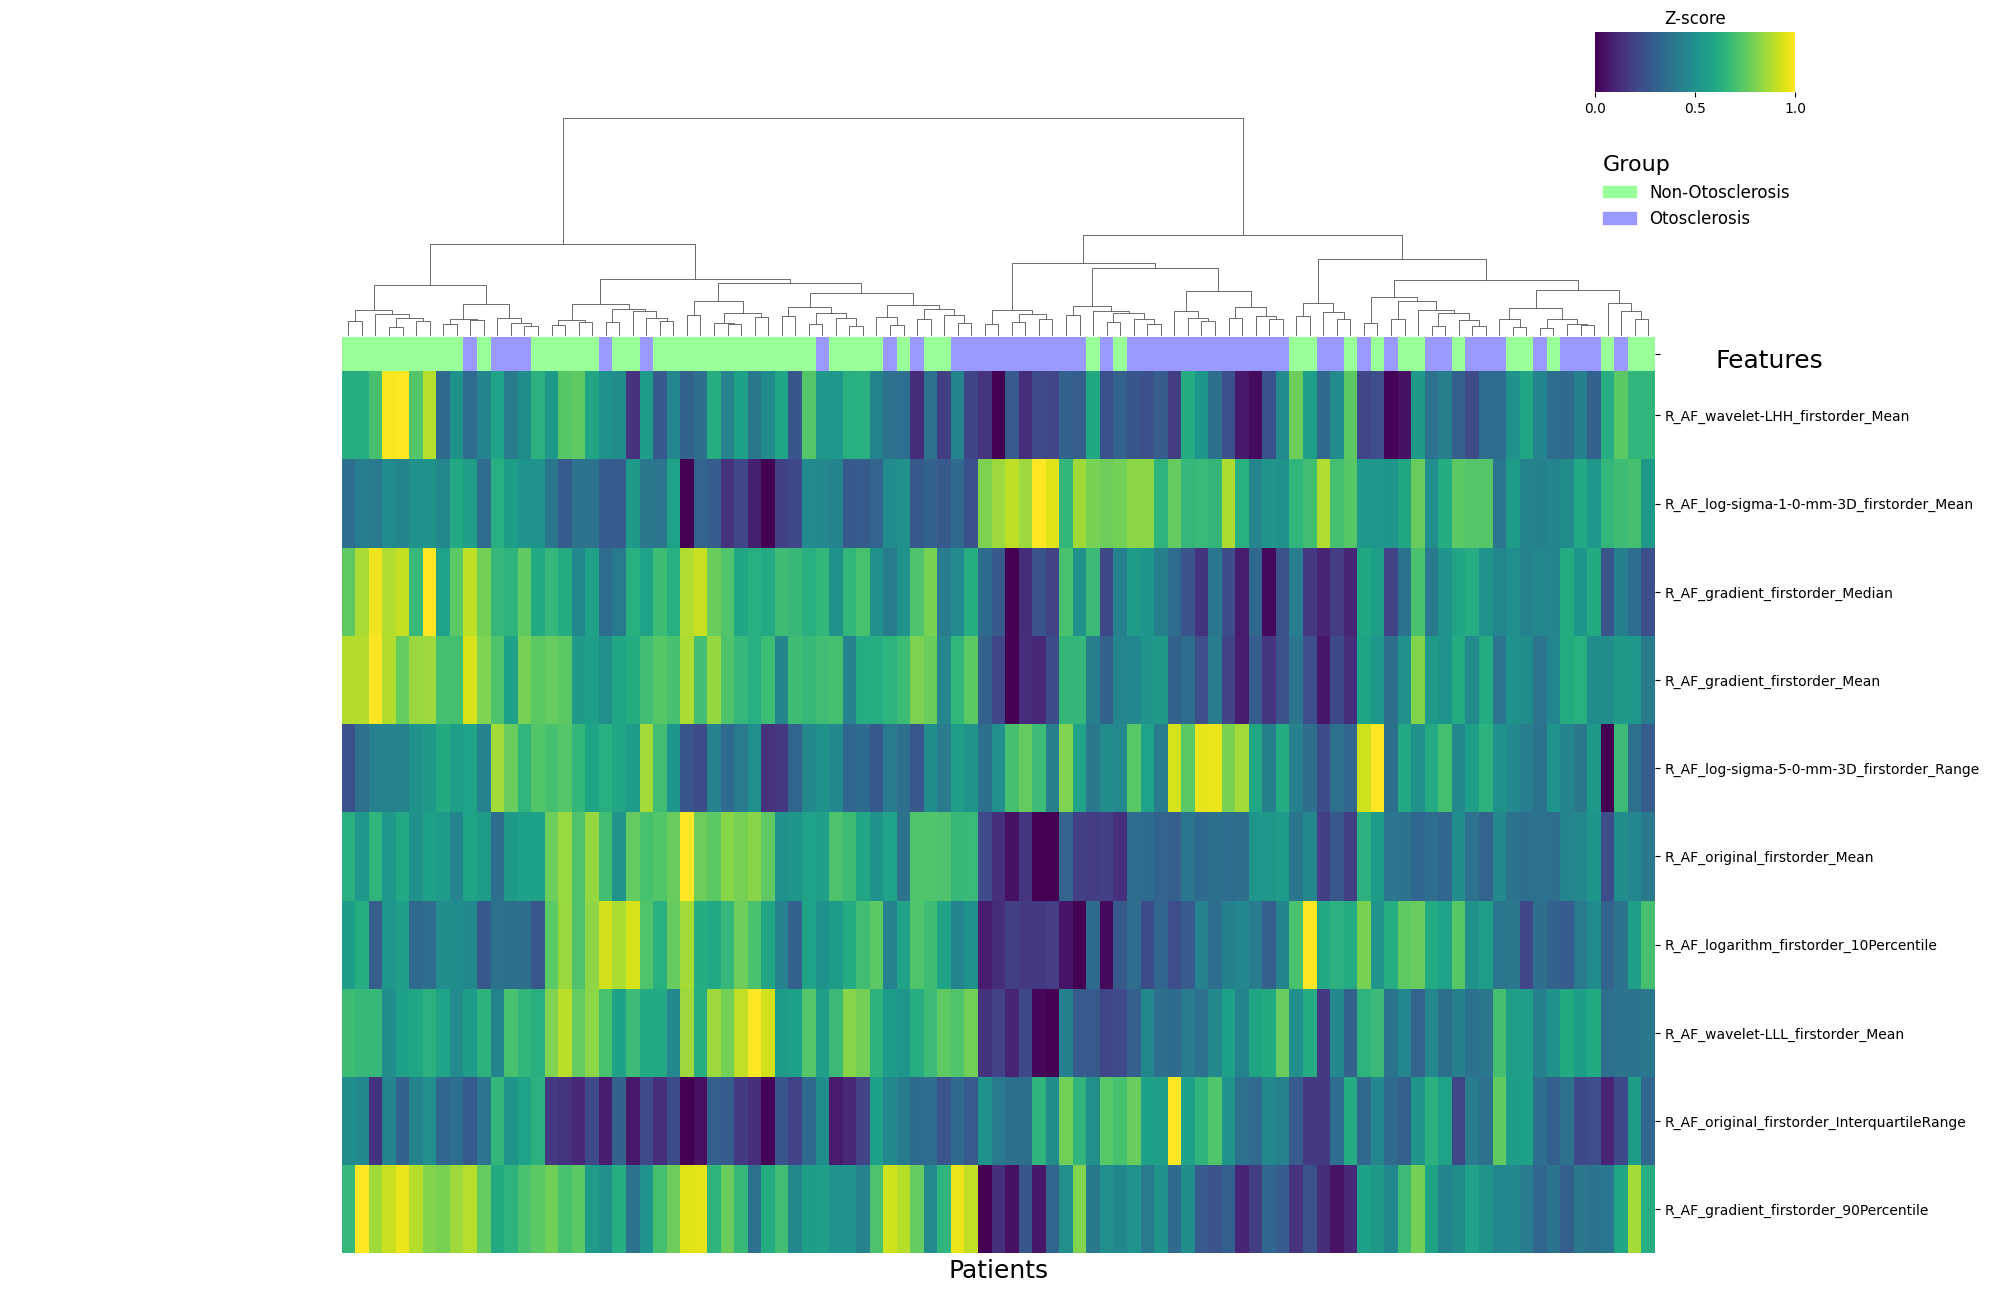

In [44]:
# Statistical 10 - most - important features
X_= X_features_sig_nonnan[2:] # exclude age and sex
y = y_sig

feature_names= features_sig[2:] #(n_features=10)
n_features= len(feature_names)

# Hierarchical Clustering for Significant Radiomic Features
hierarchical_clustering (X_=X_, y_=y, n_features=n_features, figsize=(20, 12), feature_names=feature_names, NaN='remove', name='1_HC_Most_Sig_vars')

X.shape after removing NaN: (97, 10)



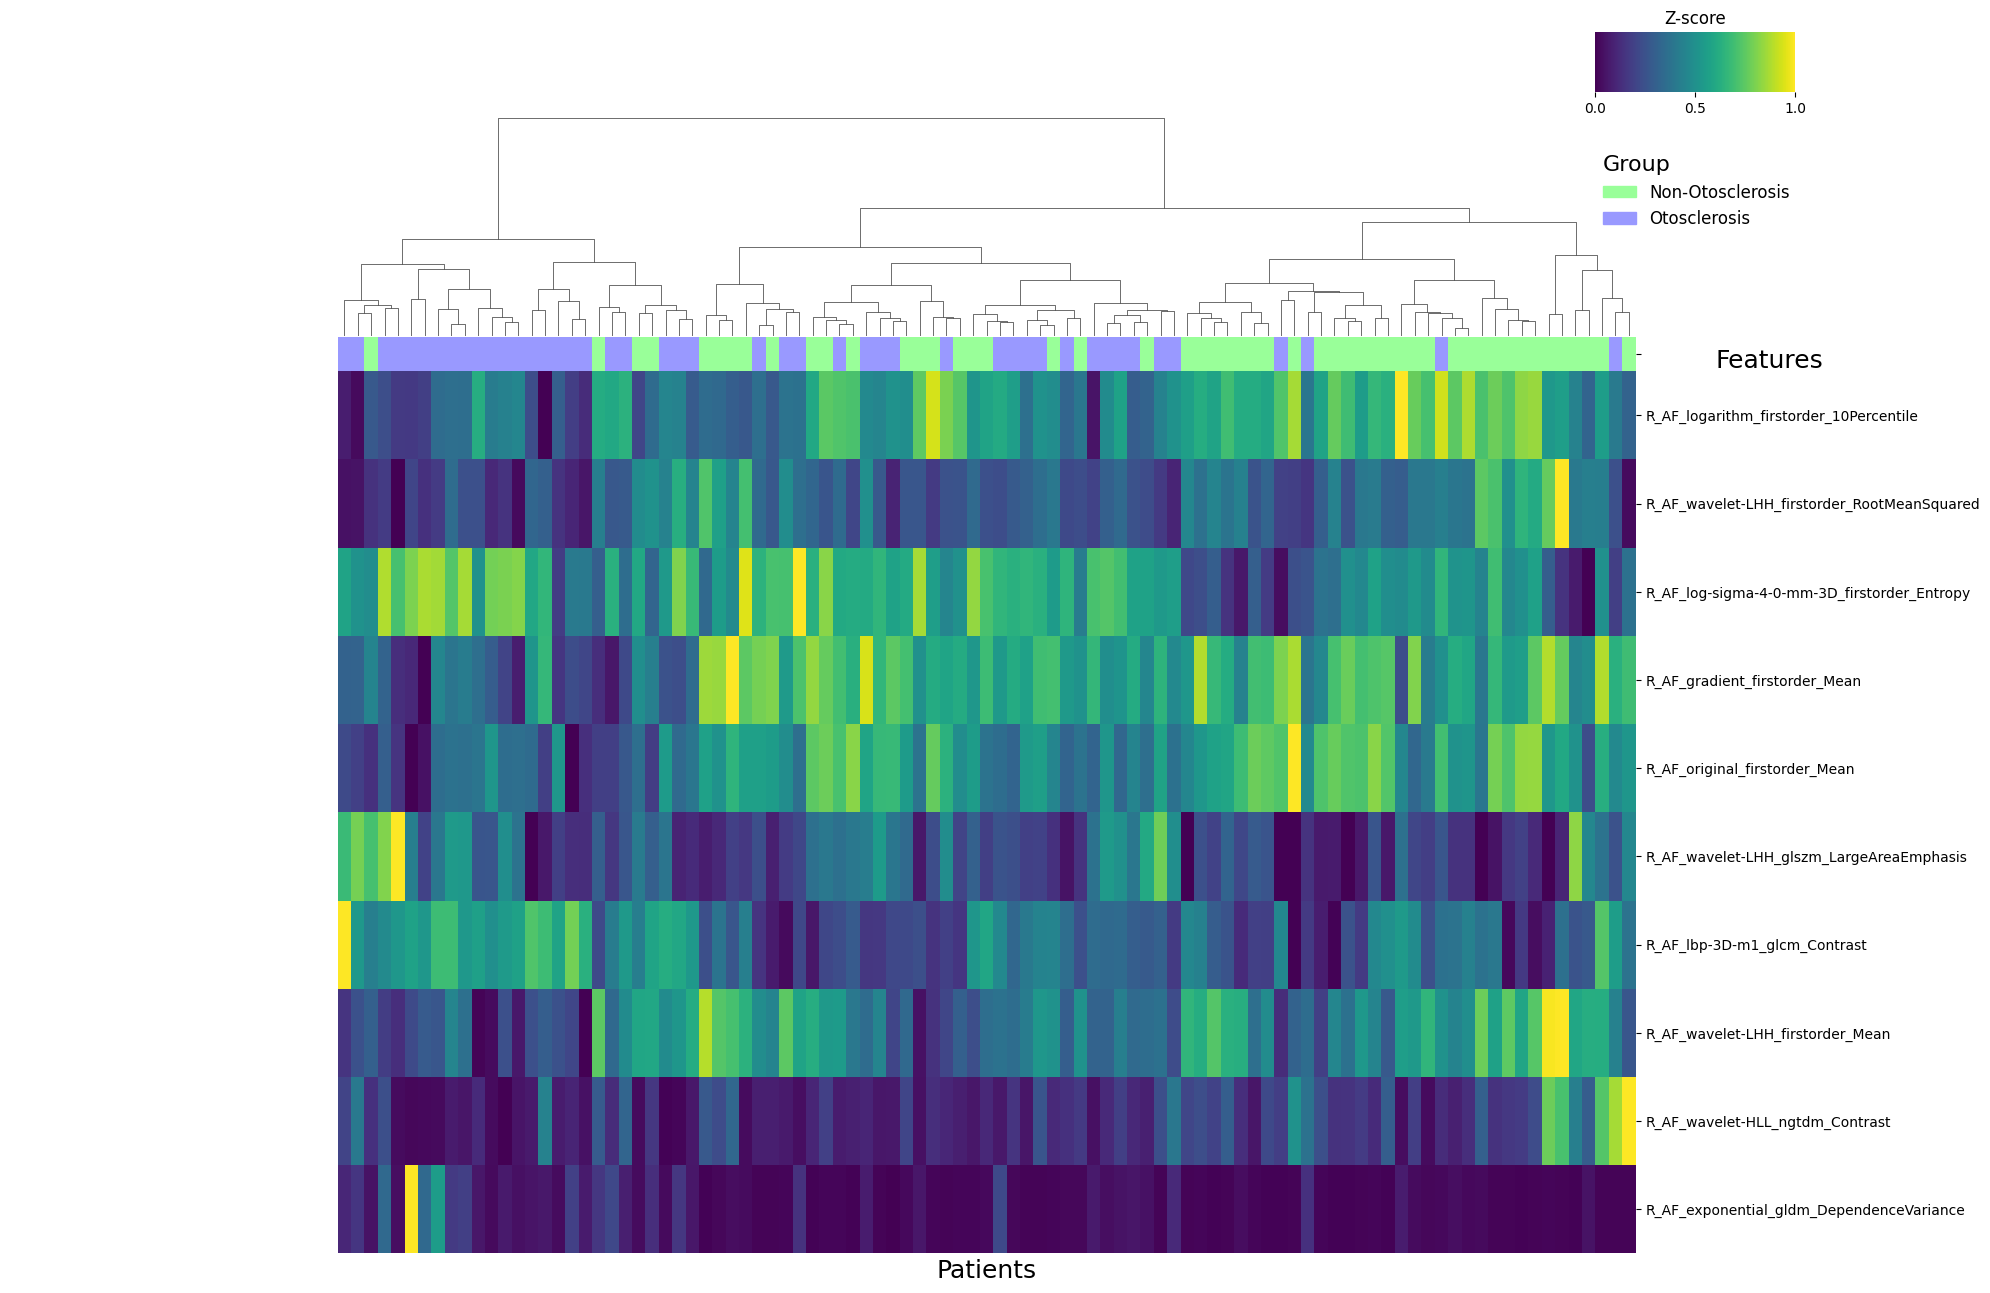

In [45]:
# Random Forest 10 - most - important features
X_= X_features_rf_nonnan[2:] # exclude age and sex
y = y_rf
feature_names= features_rf[2:] #(n_features=10)
n_features= len(feature_names)

# Hierarchical Clustering for Significant Radiomic Features
hierarchical_clustering (X_=X_, y_=y, n_features=n_features, figsize=(20, 12), feature_names=feature_names, NaN='remove', name='2_HC_Most_Imp_RF_vars')

X.shape after removing NaN: (89, 67)



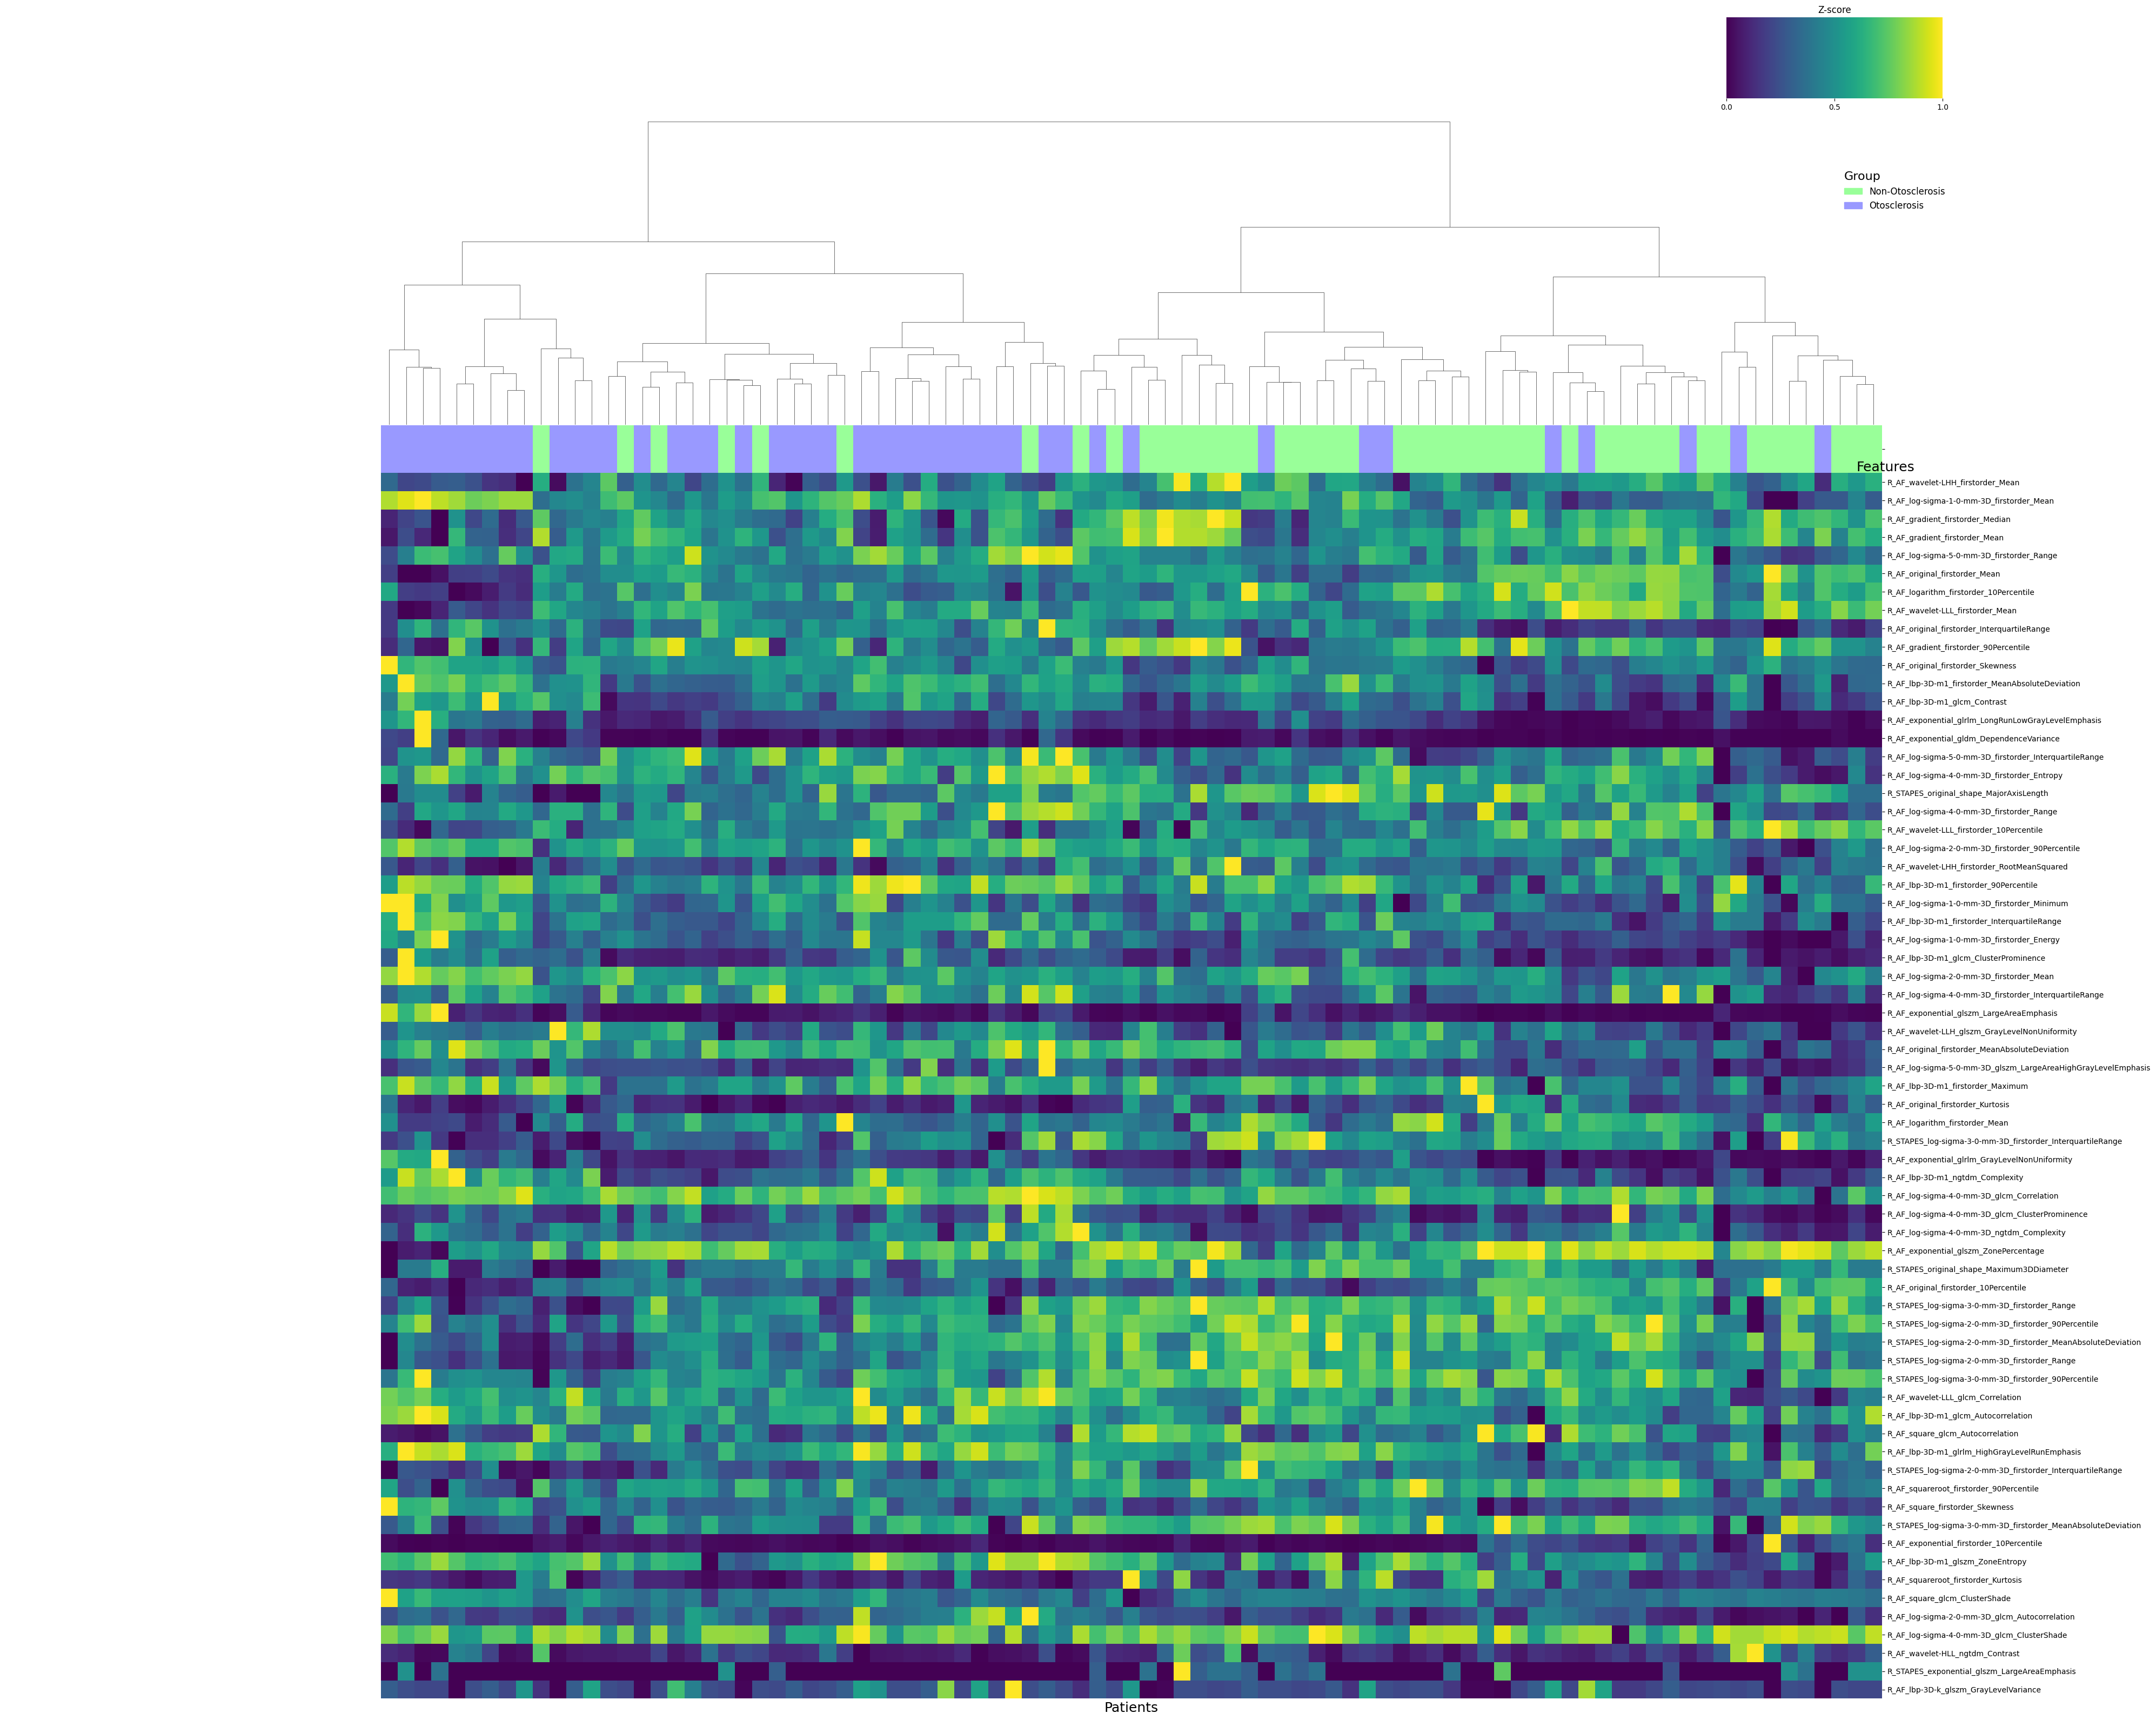

In [46]:
# Statistical significant features
X_= X_features[sig_vars]
y = y

feature_names= sig_vars
n_features= len(feature_names)

# Hierarchical Clustering for Significant Radiomic Features
hierarchical_clustering (X_=X_, y_=y, n_features=n_features, figsize=(40, 30), feature_names=feature_names, NaN='remove', name='3_HC_Sig_vars')

X.shape after removing NaN: (48, 1319)



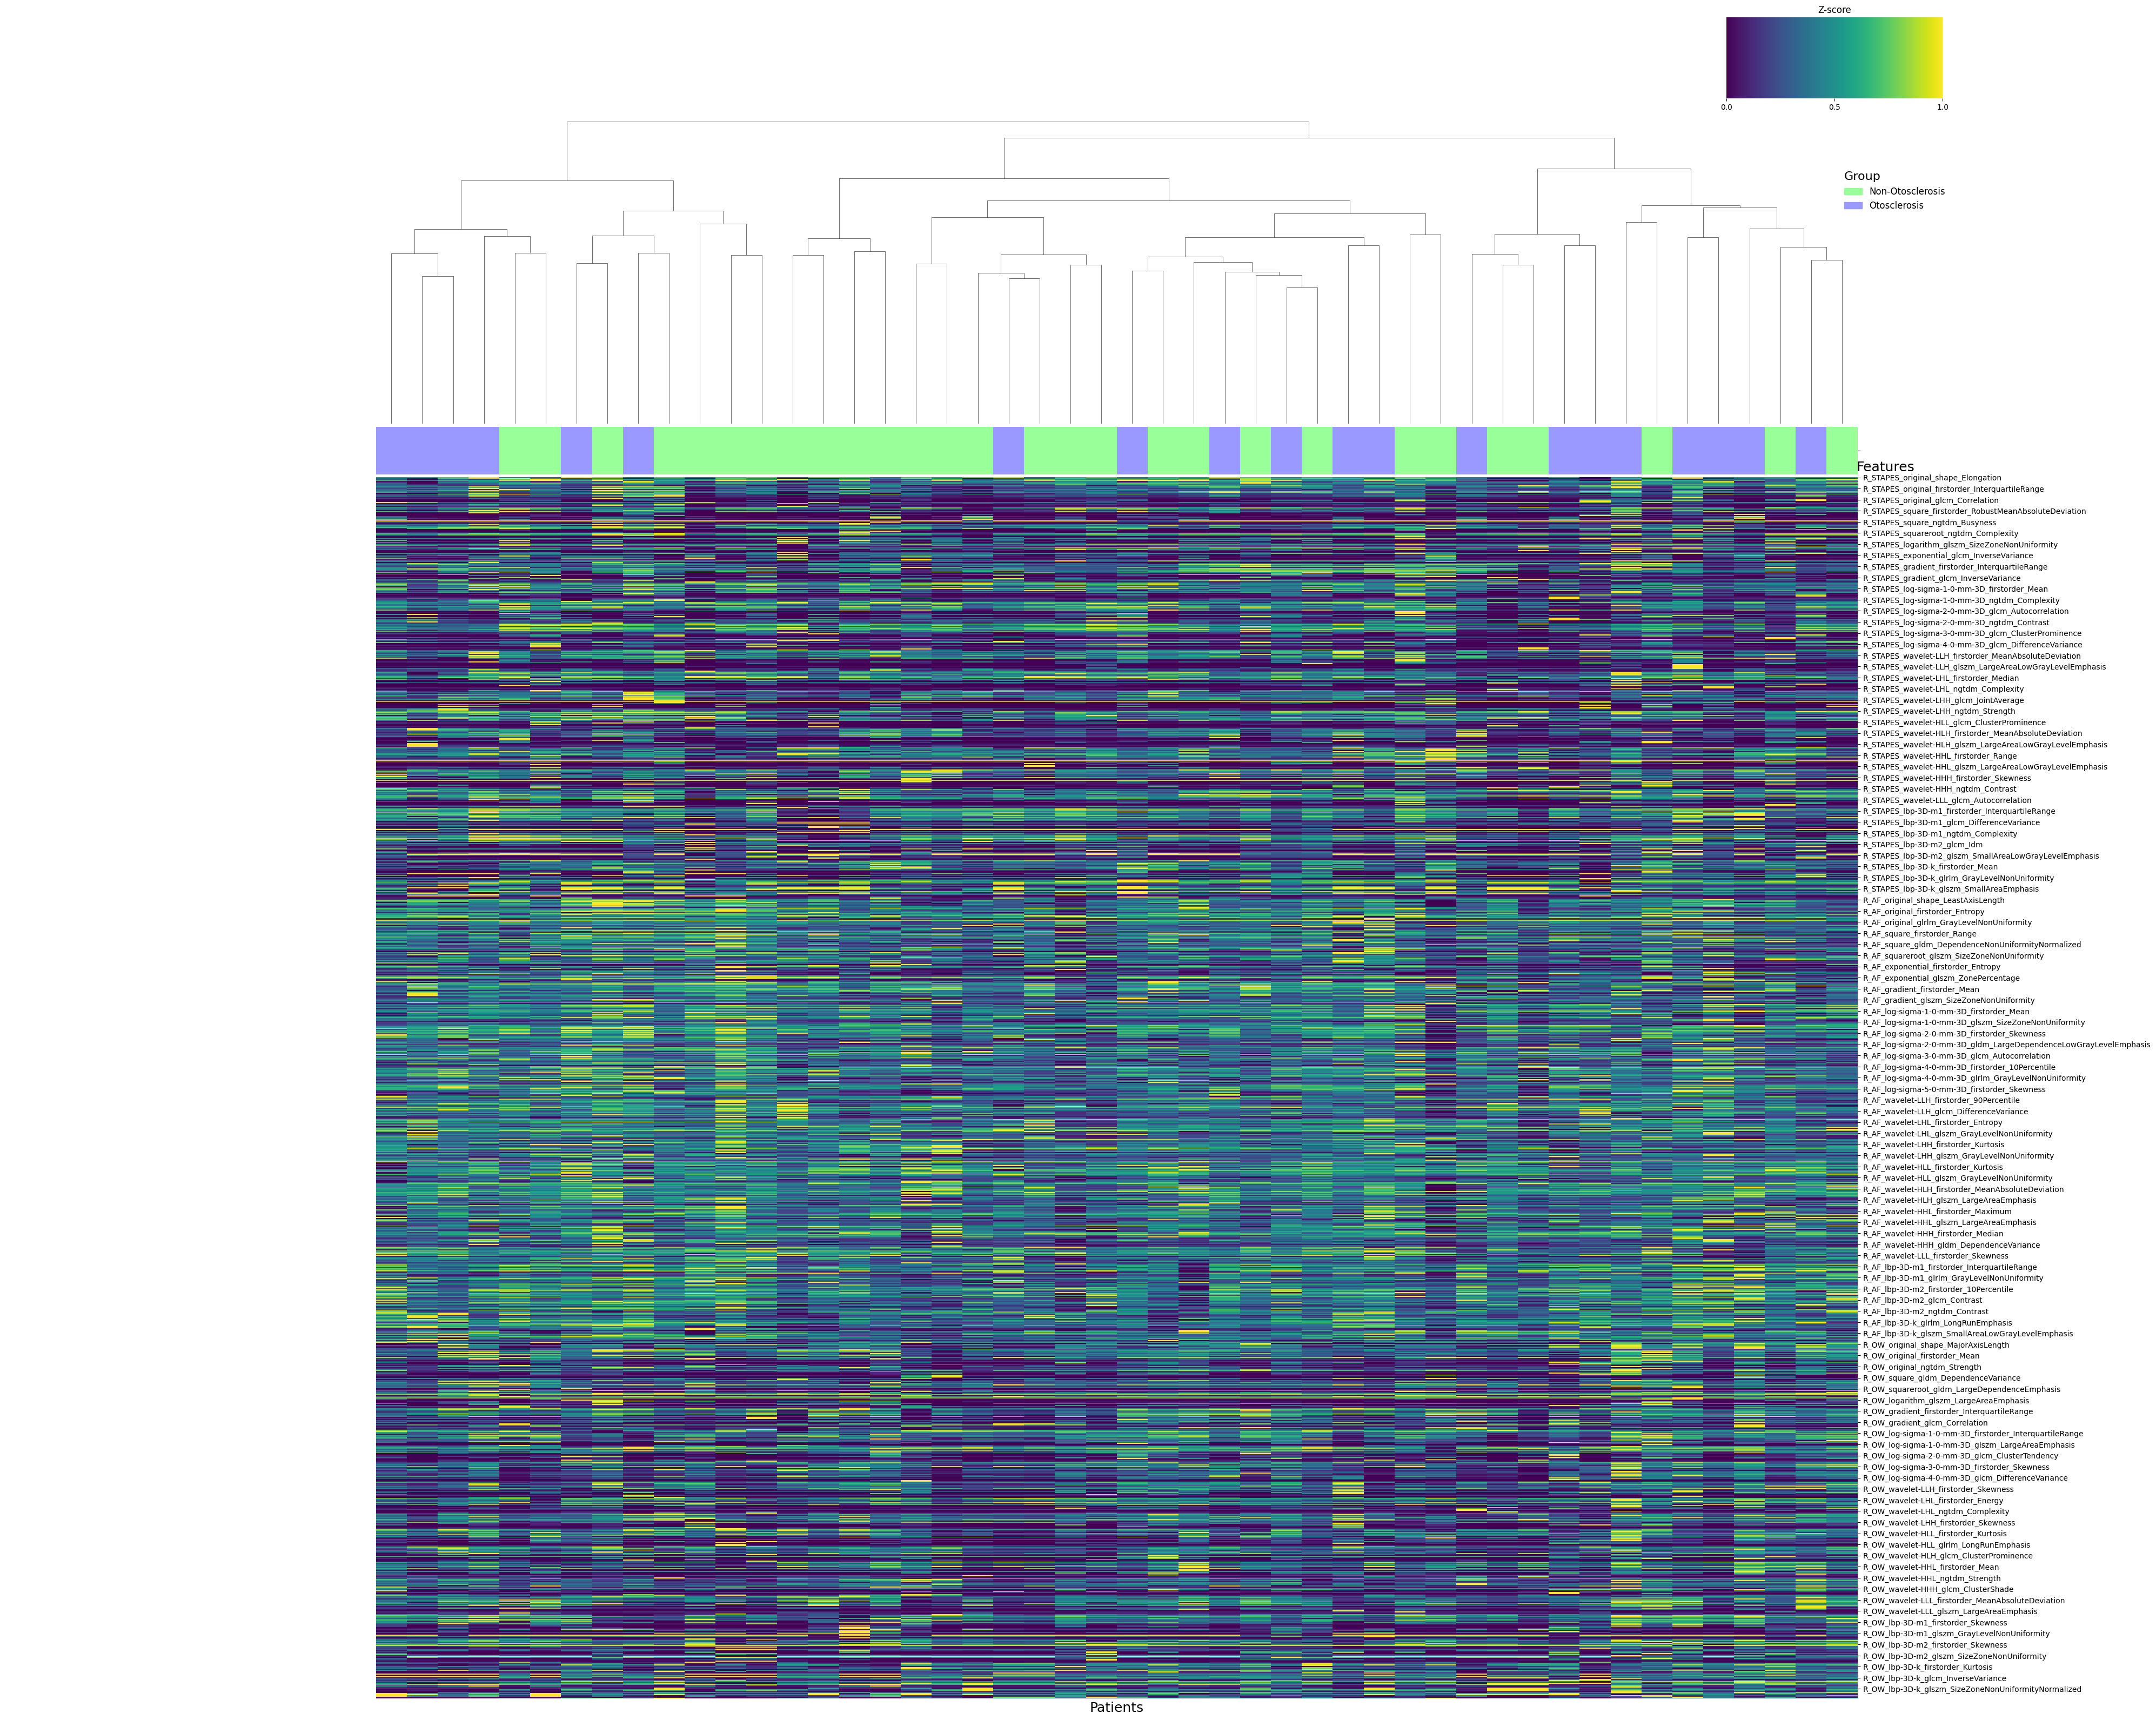

In [47]:
# Radiomic Features
X_= X_features[2:] # exclude age and sex
y= y

feature_names= X_features.columns.to_list()[2:]
n_features= len(feature_names)

# Hierarchical Clustering for Significant Radiomic Features
hierarchical_clustering (X_=X_, y_=y, n_features=n_features, figsize=(40, 30), feature_names=feature_names, NaN='remove', name='4_HC_Radiomic_Features')